I'm going to select several features that are most influential to CLV (remove multicolinearity). Using these features to conduct KMeans classification

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns  
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
import warnings                                            # Ignore warning related to pandas_profiling
warnings.filterwarnings('ignore') 

In [2]:
df = pd.read_csv('Data\IBM-Watson.csv')
df = df.rename(columns={'Customer Lifetime Value':'CLV'})
df.head()

,Customer,State,CLV,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2002/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


<font size=5> **Categorical variables**

The features 'Customer','Effective To Date','EmploymentStatus' are not important at all. Therefore, we drop them from the data frame.

In [3]:
categorical_df = df.select_dtypes(include='object')
cat_df = categorical_df.drop(['Customer','Effective To Date','EmploymentStatus'], axis = 1)

In [4]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
for col in cat_df.columns:
    cat_df[col] = lb.fit_transform(cat_df[col])
cat_df

,State,Response,Coverage,Education,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,4,0,0,0,0,1,1,0,2,0,0,5,1
1,0,0,1,0,0,1,2,1,5,2,0,0,1
2,2,0,2,0,0,1,1,1,5,0,0,5,1
3,1,0,0,0,1,1,1,0,1,0,2,3,1
4,4,0,0,0,1,0,2,1,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,1,0,0,0,1,2,1,1,3,1,3,0,1
9130,1,1,1,1,0,1,0,0,2,0,1,0,1
9131,1,0,1,0,1,1,2,0,1,0,1,0,1
9132,1,0,1,1,1,1,1,1,4,2,1,0,0


<font size=6> **Continuous variable regression**

In [5]:
import statsmodels.api as sm
from sklearn import preprocessing

<font size=4> Normalization

In [6]:
continous_var_df = df.select_dtypes(include=['int64','float'])
continous_var_df.reset_index(drop = True, inplace=True)
def stand_sca(data):
    new_data=(data-data.mean())/data.std()
    return new_data
continous_var_df=stand_sca(continous_var_df)
continous_var_df

,CLV,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,-0.762836,0.612794,-0.703886,1.678007,-1.543202,-0.422226,-0.822603,-0.169630
1,-0.149237,-1.239549,0.022690,-0.208175,-0.217322,-0.422226,2.106045,2.400606
2,0.710597,0.365690,0.429572,0.288189,-0.360661,-0.422226,-0.404225,0.455709
3,-0.052260,-1.239549,0.371446,0.288189,0.606873,-0.422226,1.687666,0.329750
4,-0.755534,0.203379,-0.587634,-0.307448,-0.145653,-0.422226,-0.822603,-1.018788
...,...,...,...,...,...,...,...,...
9129,2.241467,1.128497,-0.587634,0.288189,1.466904,-0.422226,-0.404225,-0.811890
9130,-0.714372,-0.528421,-0.413256,-0.108902,-0.719007,-0.422226,-0.822603,-0.188946
9131,0.023134,-1.239549,-0.238878,-0.605266,-0.396495,2.873088,-0.404225,1.227869
9132,-0.069932,-0.517328,0.080816,1.876553,-1.614872,-0.422226,0.014154,0.885064


Join the categorical and numerical codes

In [7]:
preprocessing.scale(continous_var_df,axis=0, with_mean=True, with_std=True, copy=True)
cat_df.reset_index(drop = True, inplace=True)
all_data_df = pd.concat([continous_var_df,cat_df], axis = 1)
all_data_df

,CLV,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,Education,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,-0.762836,0.612794,-0.703886,1.678007,-1.543202,-0.422226,-0.822603,-0.169630,4,0,0,0,0,1,1,0,2,0,0,5,1
1,-0.149237,-1.239549,0.022690,-0.208175,-0.217322,-0.422226,2.106045,2.400606,0,0,1,0,0,1,2,1,5,2,0,0,1
2,0.710597,0.365690,0.429572,0.288189,-0.360661,-0.422226,-0.404225,0.455709,2,0,2,0,0,1,1,1,5,0,0,5,1
3,-0.052260,-1.239549,0.371446,0.288189,0.606873,-0.422226,1.687666,0.329750,1,0,0,0,1,1,1,0,1,0,2,3,1
4,-0.755534,0.203379,-0.587634,-0.307448,-0.145653,-0.422226,-0.822603,-1.018788,4,0,0,0,1,0,2,1,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,2.241467,1.128497,-0.587634,0.288189,1.466904,-0.422226,-0.404225,-0.811890,1,0,0,0,1,2,1,1,3,1,3,0,1
9130,-0.714372,-0.528421,-0.413256,-0.108902,-0.719007,-0.422226,-0.822603,-0.188946,1,1,1,1,0,1,0,0,2,0,1,0,1
9131,0.023134,-1.239549,-0.238878,-0.605266,-0.396495,2.873088,-0.404225,1.227869,1,0,1,0,1,1,2,0,1,0,1,0,1
9132,-0.069932,-0.517328,0.080816,1.876553,-1.614872,-0.422226,0.014154,0.885064,1,0,1,1,1,1,1,1,4,2,1,0,0


**Multi-coliniarity test**

If VIF < 10, there is no multi-colinearity. If 10 $\leq$ VIF $\leq$ 100, there is a significant multi-colinearity. If VIF $\geq$ 100, there is a serious multi-colinearity problem.

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(all_data_df.values, all_data_df.columns.get_loc(i)) for i in all_data_df.columns]
for i in range(len(vif)):
    if vif[i] >= 100:
        print(continous_var_df.columns[i])

Therefore, there are no multi-colinearity problem

**Linear regression**

In [9]:
from sklearn import linear_model

In [10]:
model = sm.OLS(all_data_df['CLV'],all_data_df.drop('CLV',axis=1)).fit()
# model.summary()

coef_df = pd.DataFrame({"params": model.params,   # 回归系数
                        "std err": model.bse,     # 回归系数标准差
                        "t": round(model.tvalues,3),       # 回归系数T值
                        "p-values": round(model.pvalues,3) # 回归系数P值
                         })
coef_df['Absolute params']=abs(coef_df['params'])
coef_df[coef_df['p-values']<0.05].sort_values(by='Absolute params',ascending=False)

,params,std err,t,p-values,Absolute params
Monthly Premium Auto,0.416263,0.014535,28.639,0.000,0.416263
Response,-0.064463,0.027517,-2.343,0.019,0.064463
Renew Offer Type,-0.050070,0.009808,-5.105,0.000,0.050070
Marital Status,-0.038187,0.014635,-2.609,0.009,0.038187
Number of Open Complaints,-0.033055,0.009586,-3.448,0.001,0.033055
Income,0.022958,0.010988,2.089,0.037,0.022958
Number of Policies,0.022101,0.009623,2.297,0.022,0.022101
Education,0.013928,0.006810,2.045,0.041,0.013928


In [11]:
factors = coef_df[coef_df['p-values']<0.05].index
factors

Index(['Income', 'Monthly Premium Auto', 'Number of Open Complaints',
       'Number of Policies', 'Response', 'Education', 'Marital Status',
       'Renew Offer Type'],
      dtype='object')

We tried to do clustering using the features that has significant influence on the CLV. However, the means of each group does not show signifigant difference. Therefore, we conduct the K-means clustering using all variables.

<font size = 5>**K-means**

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

In [13]:
y,X = all_data_df['CLV'],all_data_df[factors]
X

,Income,Monthly Premium Auto,Number of Open Complaints,Number of Policies,Response,Education,Marital Status,Renew Offer Type
0,0.612794,-0.703886,-0.422226,-0.822603,0,0,1,0
1,-1.239549,0.022690,-0.422226,2.106045,0,0,2,2
2,0.365690,0.429572,-0.422226,-0.404225,0,0,1,0
3,-1.239549,0.371446,-0.422226,1.687666,0,0,1,0
4,0.203379,-0.587634,-0.422226,-0.822603,0,0,2,0
...,...,...,...,...,...,...,...,...
9129,1.128497,-0.587634,-0.422226,-0.404225,0,0,1,1
9130,-0.528421,-0.413256,-0.422226,-0.822603,1,1,0,0
9131,-1.239549,-0.238878,2.873088,-0.404225,0,0,2,0
9132,-0.517328,0.080816,-0.422226,0.014154,0,1,1,2


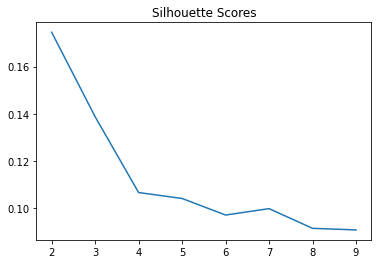

In [14]:
silhouette_scores = []
for k in range(2,10):
    estimator = KMeans(n_clusters=k)#构造聚类器
    estimator.fit(all_data_df)#聚类
    label_pred = estimator.labels_ #获取聚类标签
    silhouette_score_cluster = silhouette_score(all_data_df,label_pred)
    silhouette_scores.append(silhouette_score_cluster)

plt.title('Silhouette Scores')
plt.plot([i for i in range(2,10)],silhouette_scores)
plt.show()

The $k$ with the highest Silhouette score is the optimal number of cluster. $k=2$ shows the highest score. However, we used $k=3$ to get a more detailed customer segmentation.

In [15]:
k=3
estimator = KMeans(n_clusters=k)
estimator.fit(all_data_df)
label_pred = estimator.labels_ #Obtain the cluster labels
centroids = estimator.cluster_centers_ # Obtain the centroids
inertia = estimator.inertia_ 
all_data_df['KMeans Label'] = label_pred

To visualize the cluster, we used TSNE to reduce the dimension

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE()
tsne.fit_transform(all_data_df)  # Dimension reduction
# tsne.embedding_ can return the data after dimension reduction
print('tsne.embedding_: \n', tsne.embedding_)
tsn = pd.DataFrame(tsne.embedding_, index=X.index)  # Transform the data format
print('tsne: \n', tsne)

plt.rcParams['axes.unicode_minus'] = False  # To show negative signs

tsne.embedding_: 
 [[ 24.476969   -62.3881    ]
 [-52.262856     4.2566524 ]
 [ 40.28032    -67.41038   ]
 ...
 [ -0.46091598  56.589607  ]
 [-56.130962     9.915438  ]
 [ 25.400934   -49.562893  ]]
tsne: 
 TSNE()


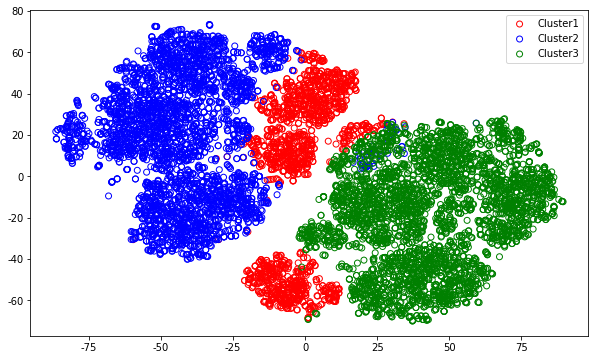

In [17]:
# Plot each segment with different color
color_style = ['red', 'blue', 'green']
plt.figure(figsize=(10,6))
for i in range(k):
    d = tsn[all_data_df[u'KMeans Label'] == i]
    plt.scatter(d[0], d[1],edgecolors=color_style[i],color=[], label='Cluster' + str(i+1))
plt.legend()
plt.show()

In [18]:
continuous = df.select_dtypes(include=['int64','float'])
continuous.reset_index(drop = True, inplace=True)
categorical = df.select_dtypes(include='object')
cat_df = categorical.drop(['Customer','Effective To Date'], axis = 1)
all = pd.concat([continuous,cat_df], axis = 1)
all['Label'] = label_pred
all.to_csv('Labeled_3.csv')

In [1]:
import pandas as pd
all = pd.read_csv('Labeled_3.csv')

In [4]:
all.EmploymentStatus = all.EmploymentStatus.apply(lambda X : 0 if X == 'Unemployed' else 1)

In [5]:
all.groupby('Label').mean()

,Unnamed: 0,CLV,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,EmploymentStatus
Label,,,,,,,,,,
0,4709.820933,8031.961484,37146.040353,97.019546,15.375158,47.998739,0.365700,2.999369,452.831268,1.0
1,4496.798315,6730.837955,37996.947268,79.105735,15.119326,47.979070,0.409622,2.974993,358.498376,1.0
2,4574.027914,9205.397402,37544.099250,105.081933,14.961747,48.172913,0.368054,2.944172,498.284087,1.0


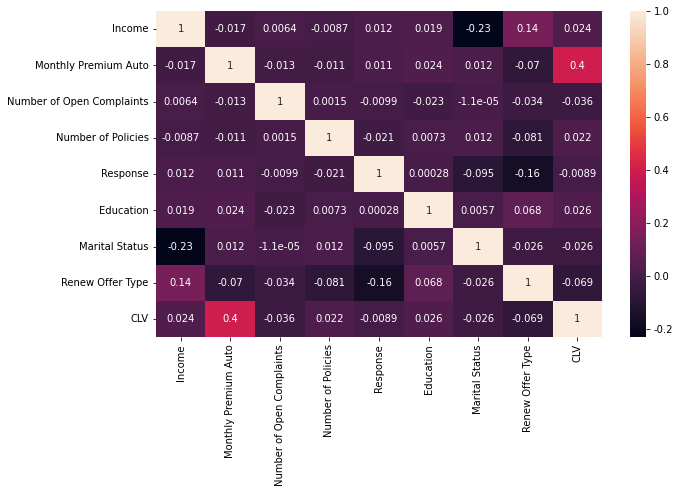

In [19]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.concat([X,y],axis=1).corr(), annot = True)
plt.show()